In [5]:
from __future__ import division
import pandas as pd
import numpy as np
import os
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import surprise
from collections import defaultdict
import random

In [6]:
def ndcg_at_k(predictions, k=10):
    dcgs = dict()
    idcgs = dict()
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        rank_est = np.arange(1, len(user_ratings[:k])+1)
        discount_est = np.log2(rank_est+1)

        rel = [np.power(2, true_r)-1 for (_, true_r) in user_ratings[:k]]

        dcgs[uid] = sum(rel/discount_est)

        user_ratings.sort(key=lambda x: x[1], reverse=True)

        rank_true = np.arange(1, len(user_ratings[:k])+1)
        discount_true = np.log2(rank_true+1)

        rel_true = [np.power(2, true_r)-1 for (_, true_r) in user_ratings[:k]]

        idcgs[uid] = sum(rel_true/discount_true)

    dcg = sum(dcgu for (_, dcgu) in dcgs.items())
    idcg = sum(idcgu for (_, idcgu) in idcgs.items())
    return dcg/idcg



In [1]:
def ap_at_k(predictions, k=10, threshold=7):

    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    aps = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        y_score = []
        y_true = []
        rec_items = user_ratings[:k]
        for item in rec_items:
            if item[0] >= threshold:
                y_score.append(1)
            else:
                y_score.append(0)

            if item[1] >= threshold:
                y_true.append(1)
            else:
                y_true.append(0)

        ap = average_precision_score(y_true, y_score)
        aps[uid] = ap

    return aps


In [8]:
def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
        
#     print 'yaha par ', top_n[212666]
    
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


In [9]:
def precision_recall_at_k(predictions, k=10, threshold=7):

    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls


## Hyper Paramter Tuning for KNN Basic

In [10]:
train = pd.read_csv('train.csv')
reader = surprise.Reader(rating_scale=(1, 10))
data = surprise.Dataset.load_from_df(train[['User-ID', 'ISBN', 'Book-Rating']], reader)
train.drop(columns = 'Unnamed: 0', inplace = True)

In [11]:
train.head()

,User-ID,ISBN,Book-Rating
0,277427,002542730X,10
1,277427,0060542128,7
2,277427,0061009059,9
3,277427,0316776963,8
4,277427,0345413903,10


In [12]:
data.split(n_folds=5)

sim_options = {'name': 'pearson',
       'user_based': False 
       }
#print sim_options.keys() damn
ks = [1, 3, 5, 9, 12]
mean_ap = []
precision = []
recall = []
fscore = []
normalized_DCG = []
mean_ap_train = []
precision_train = []
recall_train = []
fscore_train = []
normalized_DCG_train = []
N_rec = 10  

thresh = 7

In [81]:
for k_val in ks:
    print(k_val)
    algo = surprise.KNNBasic(k=k_val, sim_options=sim_options)
    pr = 0
    re = 0
    fs = 0
    ap = 0
    nd = 0
    pr_train = 0
    re_train = 0
    fs_train = 0
    ap_train = 0
    nd_train = 0
    c = 0
    mx = 0
    for trainset, testset in data.folds():
    
        algo.train(trainset)
        predictions_on_test = algo.test(testset)
    
        precisions_test, recalls_test = precision_recall_at_k(predictions_on_test, k=N_rec, threshold=thresh)
#         aps = ap_at_k(predictions_on_test, k=N_rec, threshold=thresh)
#         nDCG = ndcg_at_k(predictions_on_test,k=N_rec)
        p = sum(prec for prec in precisions_test.values()) / len(precisions_test)
#         print(p)
        pr += p
        c  += 1
    print(pr/c)
    mx = max(mx, pr/c)
print '\n', 'Maximum Precision:', mx
#         break
#         r = sum(rec for rec in recalls_test.values()) / len(recalls_test)
#         f_score = 2/(1/p+1/r)        
#         pr = pr + p
#         re = re + r
#         fs = fs + f_score
#         nd = nd + nDCG
#         ap = ap + np.nanmean(list(aps.values()))
        
#         trainset_to_test = trainset.build_testset()
#         predictions_on_train = algo.test(trainset_to_test)
#         precisions_train, recalls_train = precision_recall_at_k(predictions_on_train, k=N_rec, threshold=thresh)
    
#         aps_train = ap_at_k(predictions_on_train, k=N_rec, threshold=thresh)
#         nDCG_train = ndcg_at_k(predictions_on_train,k=N_rec)
#         p_train = sum(prec for prec in precisions_train.values()) / len(precisions_train)
#         r_train = sum(rec for rec in recalls_train.values()) / len(recalls_train)
#         f_score_train = 2/(1/p_train+1/r_train)        
#         pr_train = pr_train + p_train
#         re_train = re_train + r_train
#         fs_train = fs_train + f_score_train
#         nd_train = nd_train + nDCG_train
#         ap_train = ap_train + np.nanmean(list(aps_train.values()) )       

#     precision.append(pr/4)
#     recall.append(re/4)
#     fscore.append(fs/4)
#     mean_ap.append(ap/4) # MAP
#     normalized_DCG.append(nd/4) # NDCG

#     precision_train.append(pr_train/4)
#     recall_train.append(re_train/4)
#     fscore_train.append(fs_train/4)
#     mean_ap_train.append(ap_train/4) # MAP
#     normalized_DCG_train.append(nd_train/4) # NDCG

    
#     print("precision :", pr / 4)
#     print("recall :", re / 4)

1
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
0.8193689689701772
3
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
0.8204381675048691
5
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity

## HyperParameter Tuning for Reg_all of SVD

surprise.matrix_factorization SVD

In [82]:
train = pd.read_csv('train.csv') 
testset = train.build_anti_testset()
reader = surprise.Reader(rating_scale=(1, 10))
data = surprise.Dataset.load_from_df(train[['User-ID', 'ISBN', 'Book-Rating']], reader)

AttributeError: 'DataFrame' object has no attribute 'build_anti_testset'

In [24]:
# Tunning on regularization term
regs = [0.02, 0.1, 0.5, 1, 1.5, 2]

In [25]:
test_ndcg = []
train_ndcg = []
test_precision = []
train_precision = []
test_recall = []
train_recall = []
train_f_score = []
test_f_score = []
k = 10
threshold = 7

In [46]:
from surprise.prediction_algorithms.matrix_factorization import SVD

In [51]:
for reg in regs:
    print ('\n regularization:{}'.format(reg))
    data.split(n_folds=4)
    algo = SVD(n_factors = 100 , lr_all = 0.001, reg_all = reg)
        
        
    precisions_train = []
    recalls_train = []
    f_scores_train = []
    ndcgs_train = []

    precisions_test = []
    recalls_test = []
    f_scores_test = []
    ndcgs_test = []
        
    for trainset, testset in data.folds():

        algo.train(trainset)

        predictions_train = algo.test(trainset.build_testset())
        precision_train, recall_train= precision_recall_at_k(predictions_train, k, threshold)
        ndcg_train = ndcg_at_k(predictions_train, k)

        precisions_train.append(precision_train)
        recalls_train.append(recall_train)
        
#         print '\n', sum(precisions_train[0].values()) / len(precisions_train[0]), '\n', sum(recalls_train[0].values()) / len(recalls_train[0])
        
#         f= 2*precision_train*recall_train/(precision_train+recall_train)
#         f_scores_train.append(f)
#         ndcgs_train.append(ndcg_train)


        predictions_test = algo.test(testset)
        precision_test, recall_test = precision_recall_at_k(predictions_test, k, threshold)
#         ndcg_test = ndcg_at_k(predictions_test, k)

        precisions_test.append(precision_test)
        recalls_test.append(recall_test)
#         f= 2*precision_test*recall_test/(precision_test+recall_test)
#         f_scores_test.append(f)
#         ndcgs_test.append(ndcg_test)    


    print ("\n Training Set accuracy:")
#     print(precisions_train)
    print ("Precision: {}".format(np.mean(precisions_train[0].values())))
    train_precision.append(np.mean(precisions_train[0].values()))
#     print ("Recall: {}".format(np.mean(recalls_train[0].values()))           
#     train_recall.append(np.mean(recalls_train[0].values()))
#     print ("F-Score: {}".format(np.mean(f_scores_train[0].values())))
#     train_f_score.append(np.mean(f_scores_train))
#     print ("NDCG: {}".format(np.mean(ndcgs_train)))
#     train_ndcg.append(np.mean(ndcgs_train))

    print ("\n Test Set accuracy:")
    print ("Precision: {}".format(np.mean(precisions_test[0].values())))
    test_precision.append(np.mean(precisions_test[0].values()))
    print ("Recall: {}".format(np.mean(recalls_test[0].values())))
    test_recall.append(np.mean(recalls_test[0].values()))
#     print ("F-Score: {}".format(np.mean(f_scores_test)))
#     test_f_score.append(np.mean(f_scores_test))
#     print ("NDCG: {}".format(np.mean(ndcgs_test)))
#     test_ndcg.append(np.mean(ndcgs_test))


 regularization:0.02

 Training Set accuracy:
Precision: 0.903195918773

 Test Set accuracy:
Precision: 0.824890692641
Recall: 0.913208527391

 regularization:0.1

 Training Set accuracy:
Precision: 0.90137272456

 Test Set accuracy:
Precision: 0.818632495192
Recall: 0.912048956536

 regularization:0.5

 Training Set accuracy:
Precision: 0.89675114749

 Test Set accuracy:
Precision: 0.831537025066
Recall: 0.913403783856

 regularization:1

 Training Set accuracy:
Precision: 0.892549487715

 Test Set accuracy:
Precision: 0.82408653916
Recall: 0.919733134471

 regularization:1.5

 Training Set accuracy:
Precision: 0.890799121797

 Test Set accuracy:
Precision: 0.822131395701
Recall: 0.91824509891

 regularization:2

 Training Set accuracy:
Precision: 0.88475437325

 Test Set accuracy:
Precision: 0.82646732279
Recall: 0.922834723069


In [9]:
ks = [1,3,5,9,12]


In [97]:
sim_options = {'name': 'pearson_baseline',
       'user_based': False  # compute  similarities between items
       }

mean_ap = []
precision = []
recall = []
fscore = []
normalized_DCG = []
mean_ap_train = []
precision_train = []
recall_train = []
fscore_train = []
normalized_DCG_train = []
N_rec = 10
thresh = 7

In [98]:
for k_val in ks:
    print(k_val)
    algo = surprise.KNNBaseline(k=k_val,sim_options=sim_options)
    pr = 0
    re = 0
    fs = 0
    ap = 0
    nd = 0
    pr_train = 0
    re_train = 0
    fs_train = 0
    ap_train = 0
    nd_train = 0
    for trainset, testset in data.folds():
        algo.train(trainset)
        predictions_on_test = algo.test(testset)
        precisions_test, recalls_test = precision_recall_at_k(predictions_on_test, k=N_rec, threshold=thresh)
#         aps = ap_at_k(predictions_on_test, k=N_rec, threshold=thresh)
#         nDCG = ndcg_at_k(predictions_on_test,k=N_rec)
        p = sum(prec for prec in precisions_test.values()) / len(precisions_test)
        r = sum(rec for rec in recalls_test.values()) / len(recalls_test)
#         print(p, r)
#         f_score = 2/(1/p+1/r)        
#         pr = pr + p
#         re = re + r
#         fs = fs + f_score
#         nd = nd + nDCG
#         ap = ap + np.nanmean(aps.values())
        
        trainset_to_test = trainset.build_testset()
        predictions_on_train = algo.test(trainset_to_test)
        precisions_train, recalls_train = precision_recall_at_k(predictions_on_train, k=N_rec, threshold=thresh)
    
#         aps_train = ap_at_k(predictions_on_train, k=N_rec, threshold=thresh)
#         nDCG_train = ndcg_at_k(predictions_on_train,k=N_rec)
        p_train = sum(prec for prec in precisions_train.values()) / len(precisions_train)
        r_train = sum(rec for rec in recalls_train.values()) / len(recalls_train)
        print "Training Set :", p, r
        print "Test Set :", p_train, r_train
        
#         f_score_train = 2/(1/p_train+1/r_train)        
#         pr_train = pr_train + p_train
#         re_train = re_train + r_train
#         fs_train = fs_train + f_score_train
#         nd_train = nd_train + nDCG_train
#         ap_train = ap_train + np.nanmean(aps_train.values())        

#     precision.append(pr/4)
#     recall.append(re/4)
#     fscore.append(fs/4)
#     mean_ap.append(ap/4) # MAP
#     normalized_DCG.append(nd/4) # NDCG

#     precision_train.append(pr_train/4)
#     recall_train.append(re_train/4)
#     fscore_train.append(fs_train/4) 
#     mean_ap_train.append(ap_train/4) # MAP
#     normalized_DCG_train.append(nd_train/4) # NDCG


1
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Training Set : 0.8331911163487685 0.8635912310201258
Test Set : 1.0 0.6647170987085488
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Training Set : 0.8302148984593823 0.866407723415934
Test Set : 1.0 0.6664572720277563
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Training Set : 0.8385903495597359 0.8611859292364654
Test Set : 1.0 0.6641582340735472
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Training Set : 0.8387855906187699 0.8700406299283625
Test Set : 1.0 0.6643267835701335
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Training Set : 0.8420183572367368 0.8635035137699293
Test Set : 1.

KeyboardInterrupt: 

In [ ]:
graph_data_precision_train = []
graph_data_recall_train = []

graph_data_precision_test = []
graph_data_recall_test = []

In [99]:
sim_options = {'name': 'pearson',
       'user_based': False  # compute  similarities between items
       }

mean_ap = []
precision = []
recall = []
fscore = []
normalized_DCG = []
mean_ap_train = []
precision_train = []
recall_train = []
fscore_train = []
normalized_DCG_train = []

for k_val in ks:
    print(k_val)
    algo = surprise.KNNWithZScore(k=k_val,sim_options=sim_options)
    pr = 0
    re = 0
    fs = 0
    ap = 0
    nd = 0
    pr_train = 0
    re_train = 0
    fs_train = 0
    ap_train = 0
    nd_train = 0
    p_train_avg = 0
    r_train_avg = 0
    for trainset, testset in data.folds():
        algo.train(trainset)
        predictions_on_test = algo.test(testset)
        precisions_test, recalls_test = precision_recall_at_k(predictions_on_test, k=N_rec, threshold=thresh)
#         aps = ap_at_k(predictions_on_test, k=N_rec, threshold=thresh)
#         nDCG = ndcg_at_k(predictions_on_test,k=N_rec)
        p = sum(prec for prec in precisions_test.values()) / len(precisions_test)
        r = sum(rec for rec in recalls_test.values()) / len(recalls_test)
#         f_score = 2/(1/p+1/r)        
        pr = pr + p
        re = re + r
#         fs = fs + f_score
#         nd = nd + nDCG
#         ap = ap + np.nanmean(aps.values())
        
        trainset_to_test = trainset.build_testset()
        predictions_on_train = algo.test(trainset_to_test)
        precisions_train, recalls_train = precision_recall_at_k(predictions_on_train, k=N_rec, threshold=thresh)
    
#         aps_train = ap_at_k(predictions_on_train, k=N_rec, threshold=thresh)
#         nDCG_train = ndcg_at_k(predictions_on_train,k=N_rec)
        p_train = sum(prec for prec in precisions_train.values()) / len(precisions_train)
        r_train = sum(rec for rec in recalls_train.values()) / len(recalls_train)
        p_train_avg += p_train
        r_train_avg += r_train
    print pr/4, re/4
    graph_data_precision_test.append((k_val, pr / 4))
    graph_data_recall_test.append((k_val, re / 4))
    
    graph_data_precision_train.append((k_val, p_train_avg / 4))
    graph_data_recall_train.append((k_val, r_train_avg / 4))
    
    print p_train_avg / 4, r_train_avg / 4

1
Computing the pearson similarity matrix...
Done computing similarity matrix.


KeyboardInterrupt: 

In [25]:
print graph_data_precision_train
# graph_data_recall_train = []

# graph_data_precision_test = []
# graph_data_recall_test = []

[(1, 1.2145526921601217), (3, 1.231552859132313), (1, 1.2145526921601217), (3, 1.231552859132313), (5, 1.2345270956786176), (9, 1.2344017777209362), (12, 1.234689005414162)]


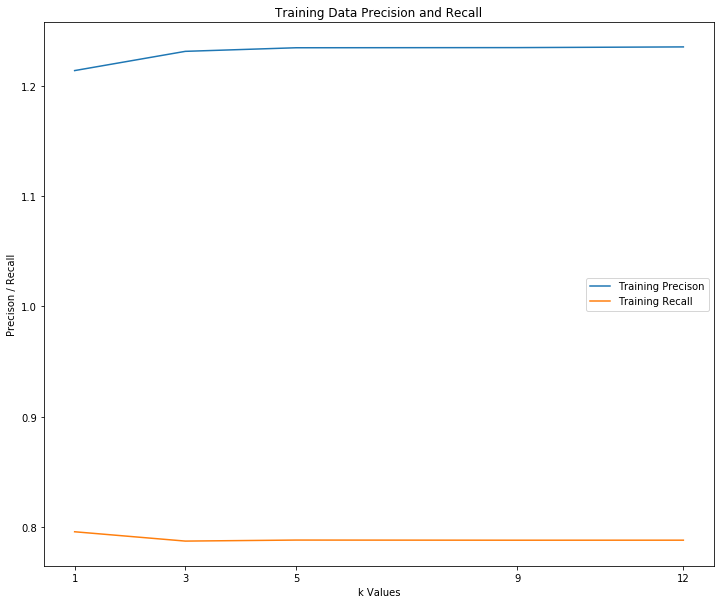

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

figure(num=None, figsize=(12, 10))
plt.plot([i for i, j in graph_data_precision_train], [j for i, j in graph_data_precision_train], label = 'Training Precison')
# [(i, j) for i, j in graph_data_precision_train]
plt.plot([i for i, j in graph_data_recall_train], [j for i, j in graph_data_recall_train], label = 'Training Recall')
[(i, j) for i, j in graph_data_recall_train]
plt.xticks([i for i, j in graph_data_recall_train])
plt.title("Training Data Precision and Recall")
plt.legend()
plt.xlabel("k Values")
plt.ylabel("Precison / Recall")

plt.savefig('training_precision_recall.png')

# plt.yticks([j for i, j in graph_data_recall_train] + [j for i, j in graph_data_precision_train])

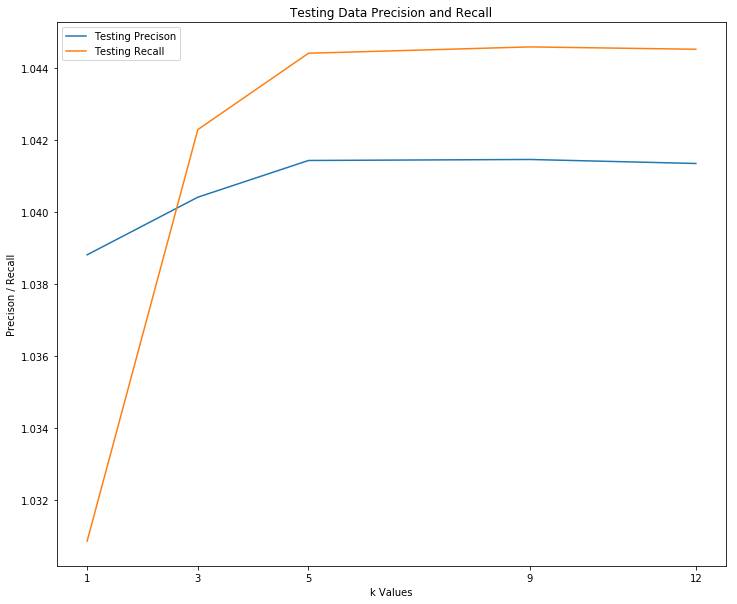

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

figure(num=None, figsize=(12, 10))
plt.plot([i for i, j in graph_data_precision_test], [j for i, j in graph_data_precision_test], label = 'Testing Precison')
# [(i, j) for i, j in graph_data_precision_train]
plt.plot([i for i, j in graph_data_recall_test], [j for i, j in graph_data_recall_test], label = 'Testing Recall')
# [(i, j) for i, j in graph_data_recall_train]
plt.xticks([i for i, j in graph_data_recall_test])
plt.legend()
plt.xlabel("k Values")
plt.ylabel("Precison / Recall")
plt.title("Testing Data Precision and Recall")

plt.savefig('testing_precision_recall.png')

# plt.yticks([j for i, j in graph_data_recall_train] + [j for i, j in graph_data_precision_train])

In [13]:
algo = surprise.KNNWithZScore(k=12, sim_options=sim_options)

In [14]:
train = pd.read_csv('train.csv')
reader = surprise.Reader(rating_scale=(1, 10))
data = surprise.Dataset.load_from_df(train[['User-ID', 'ISBN', 'Book-Rating']],  reader)
trainset = data.build_full_trainset()

In [15]:
algo.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [16]:
del data

In [17]:
testset = trainset.build_anti_testset()

In [18]:
predictions = algo.test(testset)

In [19]:
del testset

In [20]:
final = get_top_n(predictions)

In [21]:
import pickle
with open("predictions_zscore_revised.pickle", "wb") as file:
    pickle.dump(final, file)

In [64]:
 algo = SVD(n_factors = 100 , lr_all = 0.001, reg_all = 0.002)

In [12]:
train = pd.read_csv('train.csv')

In [13]:
reader = surprise.Reader(rating_scale=(1, 10))

In [14]:
data = surprise.Dataset.load_from_df(train[['User-ID', 'ISBN', 'Book-Rating']],  reader)

In [15]:
trainset = data.build_full_trainset()

In [38]:
testset = trainset.build_anti_testset()

In [39]:
algo.fit(trainset)

In [23]:
del testset

NameError: name 'testset' is not defined

In [40]:
predictions = algo.test(testset)

In [43]:
top_n = get_top_n(predictions, n=10)

In [71]:
del predictions
del top_n

In [42]:
k = 0
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])
    if k == 2:break
    k += 1

NameError: name 'top_n' is not defined

In [41]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [54]:
predictions = algo.test(testset)


AttributeError: 'SVD' object has no attribute 'trainset'

In [ ]:
testset = trainset.build_anti_testset()

In [16]:
algo = SVD(n_factors = 100 , lr_all = 0.001, reg_all = 0.02)

In [12]:
from surprise.prediction_algorithms.matrix_factorization import SVD
algo = SVD()

In [11]:
evaluate(algo, data, measures=['RMSE', 'MAE'])

NameError: name 'evaluate' is not defined

In [1]:
dataset

NameError: name 'dataset' is not defined